# Barest Soil 

### Fei Zhang @Geoscience Australia

Last Updated  Sept 2016

## Introduction

Find the barest soil Earth observations from time series analysis. The result data  will be used as input for the mineral resources uncover project:  machine-learning application.

Here are the centre point locations for 3 study aread with different vegetation/bareness relationships;

1. Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E

2. Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E

3. Woodland (remain greenish most of the time - the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E

extract a 5X5 km or 10X10km tile for each area. Then select only tiles with < 10% poor quality pixels (e.g. noise , cloud etc.). From that subset we run NDVI and then run a median kernel (3*3 ?) to smooth out noisy pixels. The kernel needs to accommodate crappy pixels as no data values. After that we calculate the average NDVI response for whole the tile. We should try a keep the tiles in chronological order because when we process all the tiles through time series and plot up the average NDVI value for each tile we will want to see trends of drying out (increased bareness) due to seasonal effects or recovery from fire scars. I suggest we look at the image tiles along each step of the work flow. There are lots of parameters (size of tile, size and shape of the kernel etc) we can change  - but as a first step this might be a good start. 

Fei we might want to have further discussions when you have selected a sub-group of tiles with good pixel quality. I suppose this first step assumes that we have a very good pixel quality mask or flag?
We have significant temporal depth - so if in doubt exclude problematic tiles.





## Interactive Computing Environment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='BarestSoil')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Retrieving Sensor Data and Compute New Features (Constructed Variables)

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

### Must identify and remove invalid observations: cloud, shadow, satuared pixels

In [3]:
#masking.make_mask?

In [4]:
def get_ndvi(prod_type, xp, yp, tp,  cloudfreeRatio = 0.5):
    
    blist= ['red', 'nir'] #, 'green', 'swir1']
    bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, measurements= blist, group_by='solar_day')
    
    bands = masking.mask_valid_data(bands)
    red= bands.red
    nir= bands.nir
# or
    #red = bands.red.where(bands.red != bands.red.attrs['nodata'])
    #nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata']) 
    # green = bands.green.where(bands.green != bands.green.attrs['nodata'])
    # swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])
# Or equivalently    
#     red= masking.mask_valid_data(bands.red)
#     nir= masking.mask_valid_data(bands.nir)
   

    # Retrieve the associated Pixel Quality datasets ls8_pq_albers
    pq_prod_type = prod_type.replace('nbar','pq')
    pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day')

    print ("NBAR and PQ slices: %s %s"%(len(bands.time), len(pq.time)))

    # to get perfect good pixels, how about cloud shadows?
    cloud_free = masking.make_mask(pq, cloud_acca='no_cloud',  cloud_fmask='no_cloud', 
                                   cloud_shadow_acca = 'no_cloud_shadow',cloud_shadow_fmask = 'no_cloud_shadow',contiguous=True).pixelquality
    
# cloud_acca='no_cloud',cloud_fmask='no_cloud', cloud_shadow_acca = 'no_cloud_shadow',cloud_shadow_fmask = 'no_cloud_shadow',
                              
    # Normalized Differenc Vegetation Index: Red and near Infrared bands

    ndvi = ((nir - red) / (nir + red)).where(cloud_free)

    # Normalized Differenc Water Index: Green and Shortwave Infrared Bands

    #ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

    #ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

    print("NDVI shape ", str(ndvi.shape))

    # xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels
    #  Weed out the low quality images
    # cloudfreeRatio = 0.8  # threshold of cloud pixel 80%

    mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

    #print(mostly_cloud_free)
    
    print("How many cloudless images selected?", mostly_cloud_free.sum().values)
    
    # Apply the time-dim mask to the 3D-array (time, x, y)
    mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
    # mostly_good_ndvi.plot(col='time', col_wrap=5)
    
    #xarray:  mostly_good_ndvi
    
    return mostly_good_ndvi

def get_ndvi_mean(mostly_good_ndvi):
    
    ndvi_mean=mostly_good_ndvi.mean(dim=['x','y'])  # average over the image pixels
    
    pdser=ndvi_mean.to_pandas()  # pd.Series
    
    
    df= pdser.to_frame(name='NDVI') # convert to dataframe
    
    df['PROD_TYPE']= prod_type  # add a new column
    
    return df



In [5]:
# Where?

# xp=(149.00, 149.20); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond


# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
# 0.1degree =~ 10km 
AOI_NAME='FireScarNT'; xp=(132.50, 132.60); yp=(-19.65, -19.55)

#Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
#AOI_NAME='Farmland'; xp=(148.14, 148.24); yp=(-30.15, -30.05) # North of Dubbo, inside NSW border

#Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
#AOI_NAME='Woodland'; xp=(147.35, 147.45); yp=(-22.92, -22.82)  # west of Rockhampton 
# woodland has a blank image in 2016-05? with NDVI=0. how to exclude it?
                
# When? a time range
tp=('1980-01-01', '2016-12-31')


#To see the function signature?
#dc.load?


In [6]:
prod_type='ls8_nbar_albers'

pq_prod_type = prod_type.replace('nbar','pq')

good_ndvi=get_ndvi(prod_type, xp,yp,tp)


NBAR and PQ slices: 81 82
('NDVI shape ', '(67, 447, 421)')
('How many cloudless images selected?', array(51))


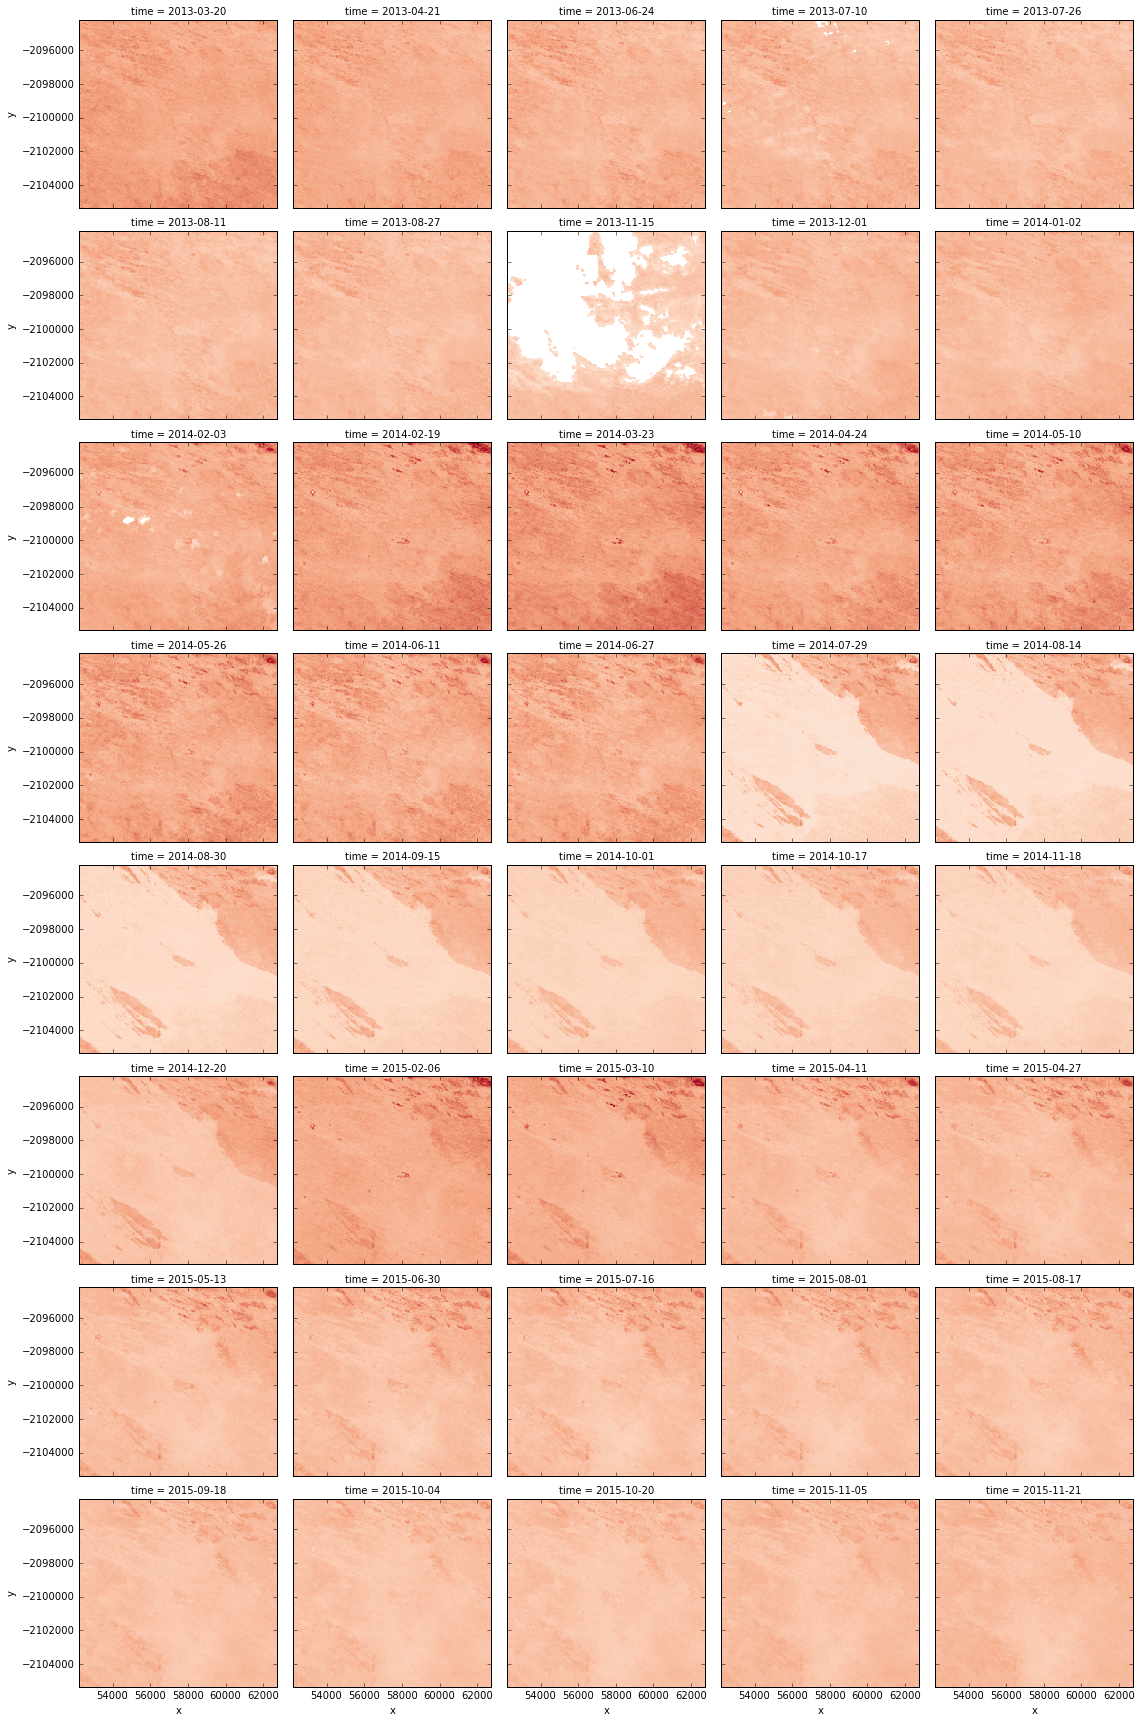

In [37]:
good_ndvi.plot(col='time', col_wrap=5, add_colorbar=False)

In [38]:
df_ndvi_ls8=get_ndvi_mean(good_ndvi)
df_ndvi_ls8.sort_values('NDVI').head(10)

,NDVI,PROD_TYPE
time,,
2014-07-29,0.146852,ls8_nbar_albers
2014-08-14,0.150169,ls8_nbar_albers
2014-08-30,0.157027,ls8_nbar_albers
2014-11-18,0.160124,ls8_nbar_albers
2014-09-15,0.164522,ls8_nbar_albers
2014-10-17,0.166818,ls8_nbar_albers
2014-10-01,0.167365,ls8_nbar_albers
2013-11-15,0.170173,ls8_nbar_albers
2015-10-20,0.189281,ls8_nbar_albers


In [9]:
# prod_type='ls7_nbar_albers'
# df_ndvi_ls7=get_ndvi_mean(good_ndvi)

# # ls5
# prod_type='ls5_nbar_albers'
# df_ndvi_ls5=get_ndvi_mean(good_ndvi)


In [10]:
# ndvi578=pandas.concat([df_ndvi_ls5, df_ndvi_ls7, df_ndvi_ls8])

# only Landsat-8

ndvi578 =df_ndvi_ls8

In [39]:
ndvi578.shape

(40, 2)

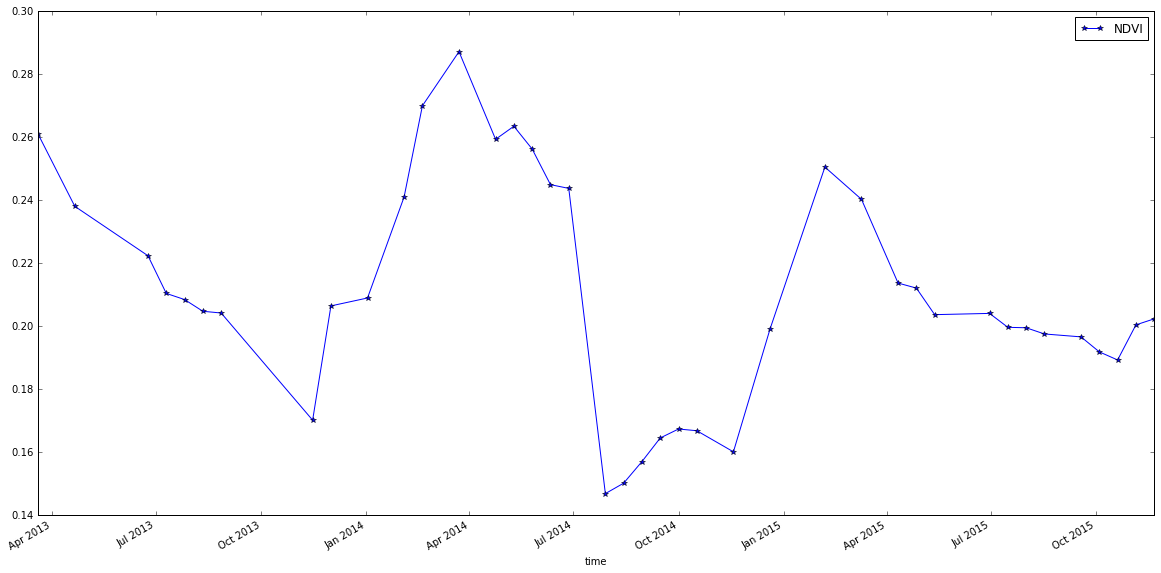

In [40]:

ndvi578.plot( figsize=(20,10),  marker='*' )

In [13]:
#ndvi_mean

In [14]:
outcsvfile='meanNDVI578_%s.csv'% (AOI_NAME)

ndvi578.to_csv(outcsvfile)  #('/tmp/meanNDVI578_FireScarNT.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba740dc090>]], dtype=object)

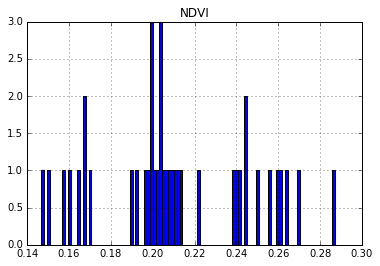

In [15]:
ndvi578.hist(bins=100)

In [16]:
p10= ndvi578.quantile(0.1)
p90= ndvi578.quantile(0.9)

bot_tenperc=ndvi578[(ndvi578['NDVI'] <= p10[0])].dropna()
top_tenperc=ndvi578[(ndvi578['NDVI'] >= p90[0])].dropna()

In [17]:
outcsvfile2='meanNDVI578_%s_bot10pc.csv'% (AOI_NAME)
bot_tenperc.to_csv(outcsvfile2)

outcsvfile3='meanNDVI578_%s_top10pc.csv'% (AOI_NAME)
top_tenperc.to_csv(outcsvfile3)

In [18]:
top_tenperc.head

<bound method DataFrame.head of                 NDVI        PROD_TYPE
time                                 
2013-03-20  0.260915  ls8_nbar_albers
2014-02-19  0.269975  ls8_nbar_albers
2014-03-23  0.287160  ls8_nbar_albers
2014-05-10  0.263476  ls8_nbar_albers>

In [19]:
p10

NDVI    0.164082
dtype: float64

In [20]:
bot_tenperc.head(100)

,NDVI,PROD_TYPE
time,,
2014-07-29,0.146852,ls8_nbar_albers
2014-08-14,0.150169,ls8_nbar_albers
2014-08-30,0.157027,ls8_nbar_albers
2014-11-18,0.160124,ls8_nbar_albers


In [21]:
#http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter

from skimage import data
from skimage.morphology import disk
from skimage.filters.rank import median
# >>> img = data.camera()
# >>> med = median(img, disk(5))

In [22]:
def filtered_ndvi_mean(ndvi_imgs, ndisk=5):
    """ apply a spatial filter to the input ndvi_imgs array
    return a pandas dataframe of mean NDVI for the images.
    ndisk=5 is the default size of the disk filter
    See http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
    """

    mydict={}
    for it in xrange(0, len(ndvi_imgs.time)):
        # apply median filter to get an image meds for this timeslice
        img=ndvi_imgs.isel(time=it)
        imask= ~np.isnan(img)
        meds = median(img,disk(ndisk), mask=imask)  
        #plt.imshow(meds)
        mydict.update({ndvi_imgs.time[it].values: meds.mean()})

    # convert mydict to pandas dataframe, with proper column names and index
    pdf=pandas.DataFrame(mydict.items(), columns=['Date', 'NDVI'])
    pdf.set_index('Date', inplace=True)
    
    return pdf

In [23]:
scaled_good_ndvi = 128*(1+good_ndvi) # to unint8 or uint16 for scikit-image filter input

uint8_good_ndvi=scaled_good_ndvi.astype('uint8')

pdf5 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=5)

pdf5.head()

,NDVI
Date,
2013-03-20,160.779459
2013-04-21,157.862398
2014-12-20,152.867839
2014-06-11,158.695664
2014-03-23,164.074862


In [24]:
pdf0=filtered_ndvi_mean( uint8_good_ndvi, ndisk=0)

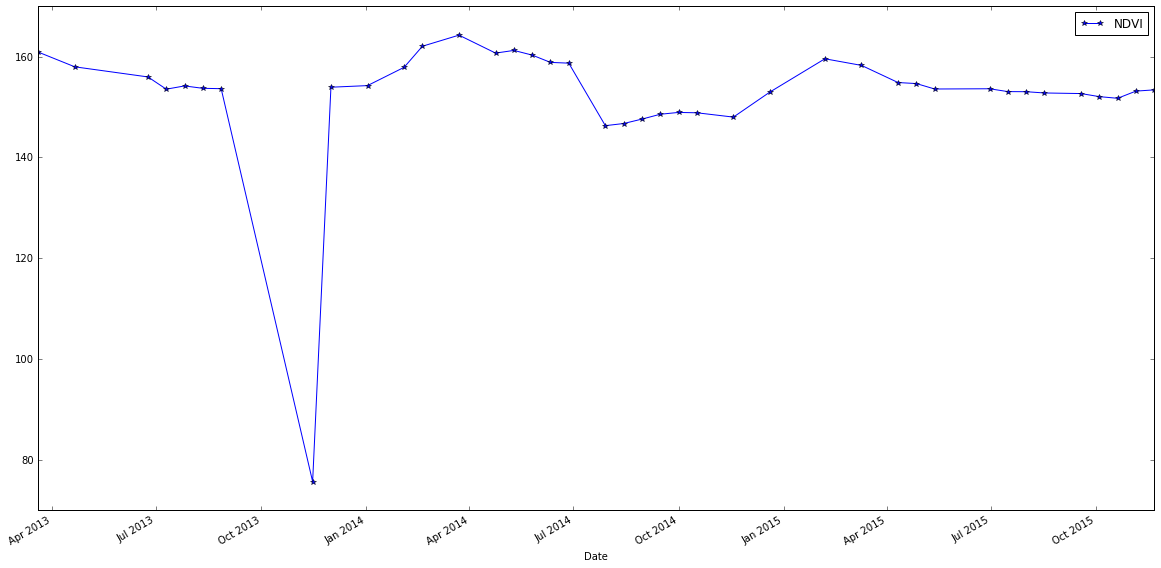

In [25]:
# plt.figure( )
pdf0.plot(figsize=(20,10), marker='*' )

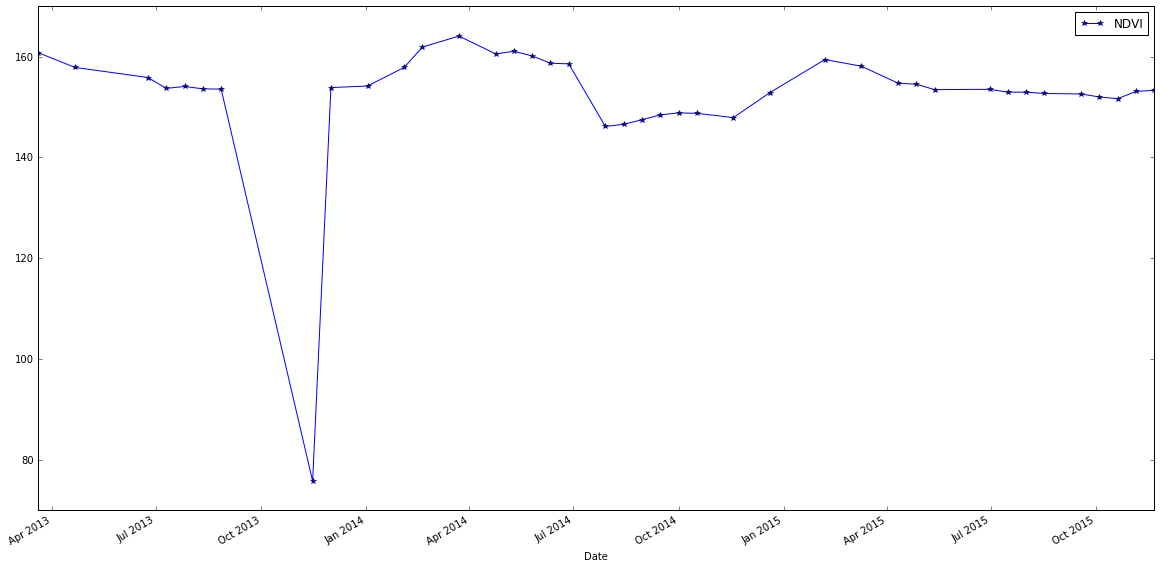

In [26]:
pdf5.plot(figsize=(20,10), marker='*' )

(40, 1)


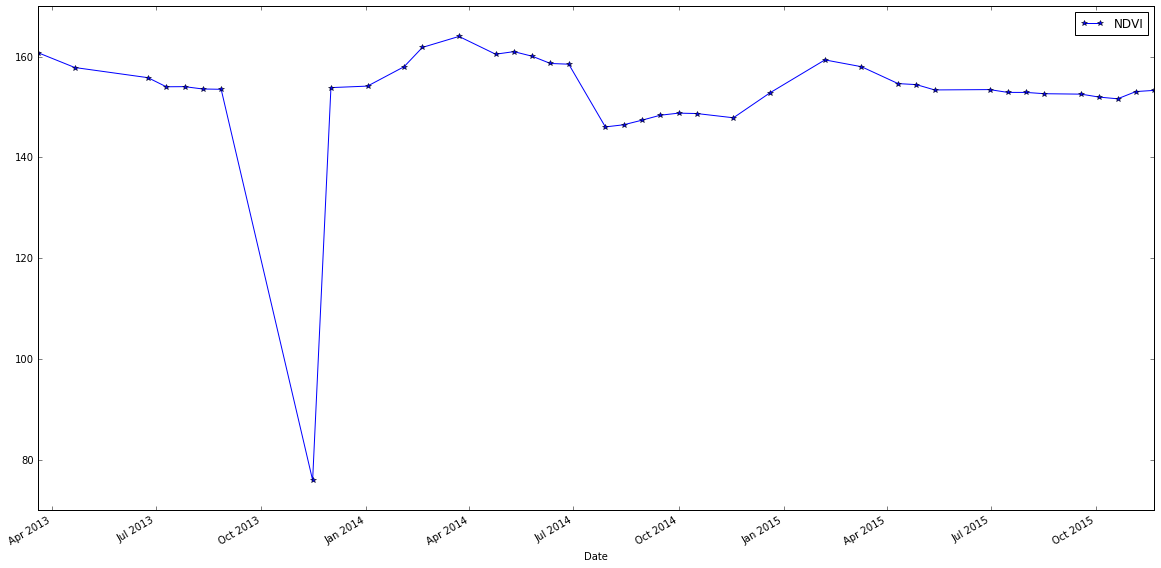

In [27]:
pdf10 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=10)

print(pdf10.shape)
pdf10.plot(figsize=(20,10), marker='*' )

(40, 1)


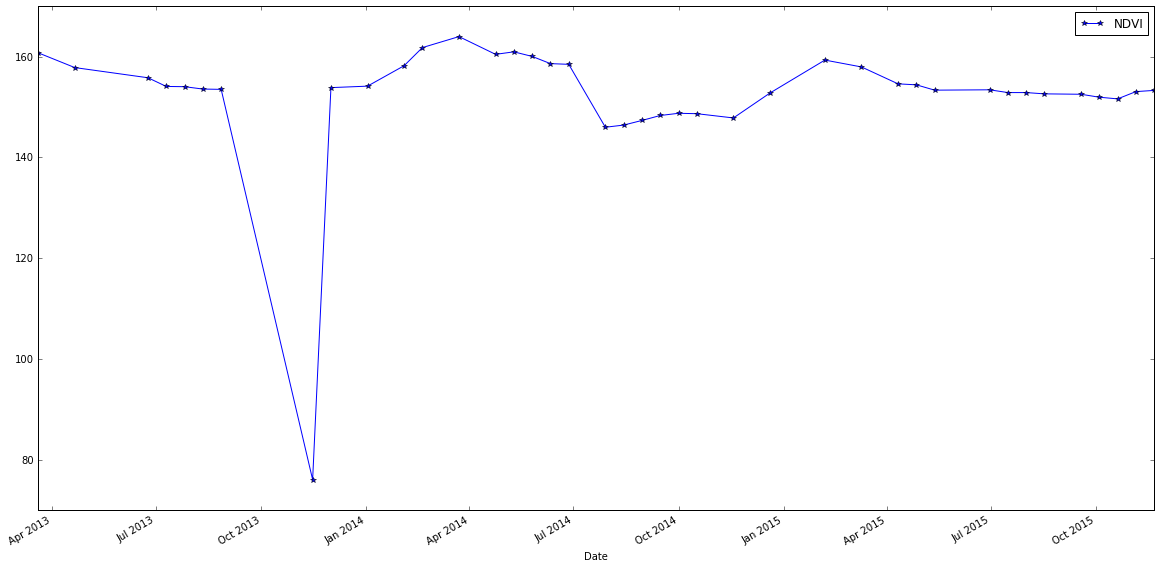

In [28]:
pdf15 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=15)

print(pdf15.shape)
pdf15.plot(figsize=(20,10), marker='*' )

(40, 1)


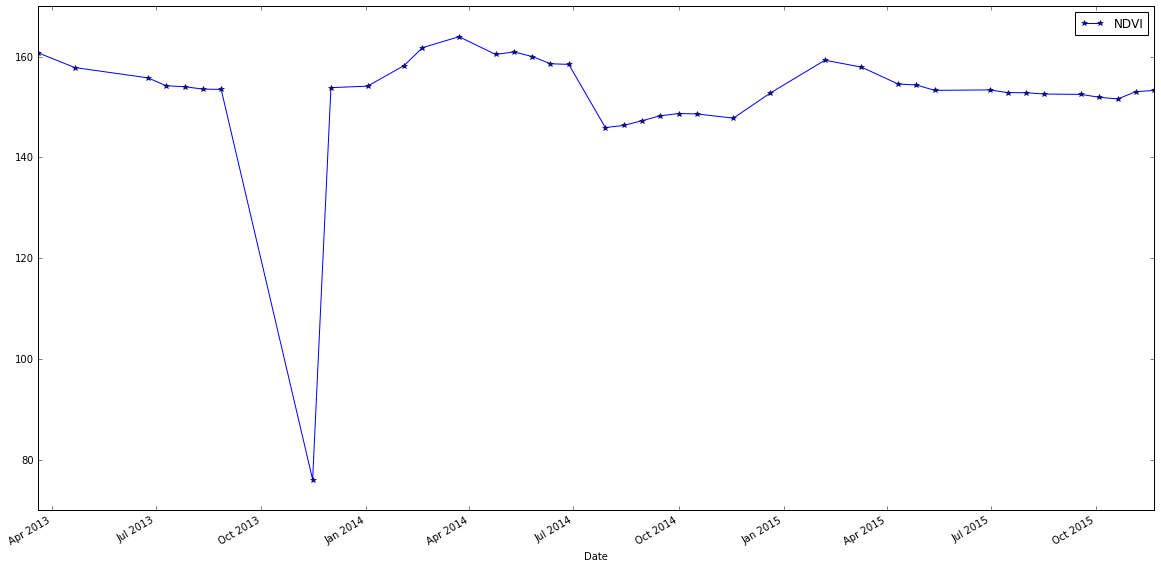

In [29]:
pdf20 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=20)

print(pdf15.shape)
pdf20.plot(figsize=(20,10), marker='*' )

In [30]:
# no filter, original ndvi images
ndvi578.sort_values('NDVI').head(40)

,NDVI,PROD_TYPE
time,,
2014-07-29,0.146852,ls8_nbar_albers
2014-08-14,0.150169,ls8_nbar_albers
2014-08-30,0.157027,ls8_nbar_albers
2014-11-18,0.160124,ls8_nbar_albers
2014-09-15,0.164522,ls8_nbar_albers
2014-10-17,0.166818,ls8_nbar_albers
2014-10-01,0.167365,ls8_nbar_albers
2013-11-15,0.170173,ls8_nbar_albers
2015-10-20,0.189281,ls8_nbar_albers


In [31]:

for irow in xrange (0, pdf5.shape[0]):
    print(ndvi578.index[irow],ndvi578.iloc[irow][0], pdf5.iloc[irow].NDVI, pdf10.iloc[irow].NDVI, pdf15.iloc[irow].NDVI, pdf20.iloc[irow].NDVI)

(Timestamp('2013-03-20 00:00:00'), 0.26091534881067335, 160.77945872988039, 160.7583095537949, 160.74832480458267, 160.74251675195418)
(Timestamp('2013-04-21 00:00:00'), 0.23806010960878238, 157.86239750886088, 157.83490357994972, 157.82213436634837, 157.82479661188074)
(Timestamp('2013-06-24 00:00:00'), 0.22236951716472628, 152.86783890491904, 152.81819679361487, 152.77896985445329, 152.73716037770942)
(Timestamp('2013-07-10 00:00:00'), 0.21040845480189266, 158.69566441890248, 158.63532018683543, 158.60660406935654, 158.58449839787019)
(Timestamp('2013-07-26 00:00:00'), 0.20846138240364459, 164.07486170670663, 164.00252408508558, 163.968908585609, 163.94973085282192)
(Timestamp('2013-08-11 00:00:00'), 0.20473838659000393, 146.56301976225777, 146.47192420305333, 146.41198382459999, 146.34101717972018)
(Timestamp('2013-08-27 00:00:00'), 0.20419053912082616, 154.72053861318795, 154.6445291120003, 154.5926764335475, 154.5628284631776)
(Timestamp('2013-11-15 00:00:00'), 0.17017338115304079

In [32]:
bot_tenperc.head()

,NDVI,PROD_TYPE
time,,
2014-07-29,0.146852,ls8_nbar_albers
2014-08-14,0.150169,ls8_nbar_albers
2014-08-30,0.157027,ls8_nbar_albers
2014-11-18,0.160124,ls8_nbar_albers


In [33]:
(147.901603-128)/128

0.15548127343749996

In [34]:
pdf15.sort_values('NDVI').head(40)

,NDVI
Date,
2013-11-15,76.063745
2014-07-29,145.985493
2014-08-14,146.411984
2014-08-30,147.331149
2014-11-18,147.829228
2014-09-15,148.314575
2014-10-17,148.674382
2014-10-01,148.751178
2015-10-20,151.611790


In [35]:
top_tenperc.head(5)

,NDVI,PROD_TYPE
time,,
2013-03-20,0.260915,ls8_nbar_albers
2014-02-19,0.269975,ls8_nbar_albers
2014-03-23,0.287160,ls8_nbar_albers
2014-05-10,0.263476,ls8_nbar_albers


In [36]:
done

NameError: name 'done' is not defined

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm
